In [5]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [6]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
# we'll read both of these values and the original input and irrelevant tcrs
X_cdr3s = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
X_epitopes = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)
hit = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
irr = pd.read_csv('../outputs/model_v3/full.control.X.csv', index_col=0)
irr = irr.reset_index().iloc[:, 1:]

In [8]:
# retrieve values and aucs
fprs, tprs, aucs, accs = [], [], [], []

In [9]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# complete 10 iterations
for seed in range(10):
    # grab a subset
    np.random.seed(seed)
    n_rows = 50000
    perc_train = 0.75

    # training and during training testing
    # > subset target
    idxs = np.random.choice(hit.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    hit_train, hit_test = hit.loc[idxs], hit.loc[idys]
    # > subset control
    idxs = np.random.choice(irr.index, size=n_rows, replace=False)
    idxs, idys = idxs[:round(n_rows * perc_train)], idxs[round(n_rows * perc_train):]
    irr_train, irr_test = irr.loc[idxs], irr.loc[idys]

    # validation
    # > subset target
    val_idxs = hit.index[~hit.index.isin(hit_train.index.union(hit_test.index))]
    hit_val = hit.loc[val_idxs]
    # > subset control
    val_idxs = irr.index[~irr.index.isin(irr_train.index.union(irr_test.index))]
    irr_val = irr.loc[val_idxs]

    # create X for training
    X_train = pd.concat([hit_train, irr_train], axis=0).reset_index().iloc[:, 1:]
    X_train_cdr3s = X_cdr3s.loc[X_train['CDR3']].reset_index().iloc[:, 1:]
    X_train_epitopes = X_epitopes.loc[X_train['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_train_cdr3s.columns = 'cdr3:' + X_train_cdr3s.columns
    X_train_epitopes.columns = 'ag:' + X_train_epitopes.columns
    X_train = X_train_cdr3s.join(X_train_epitopes)
    # grab y for training
    y_train = pd.concat([pd.Series(np.ones(hit_train.shape[0])), pd.Series(np.zeros(irr_train.shape[0]))], axis=0).astype(int)
    y_train = y_train.reset_index().iloc[:, 1:][0]

    # create X for testing
    X_test = pd.concat([hit_test, irr_test], axis=0).reset_index().iloc[:, 1:]
    X_test_cdr3s = X_cdr3s.loc[X_test['CDR3']].reset_index().iloc[:, 1:]
    X_test_epitopes = X_epitopes.loc[X_test['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_test_cdr3s.columns = 'cdr3:' + X_test_cdr3s.columns
    X_test_epitopes.columns = 'ag:' + X_test_epitopes.columns
    X_test = X_test_cdr3s.join(X_test_epitopes)
    # grab y for testing
    y_test = pd.concat([pd.Series(np.ones(hit_test.shape[0])), pd.Series(np.zeros(irr_test.shape[0]))], axis=0).astype(int)
    y_test = y_test.reset_index().iloc[:, 1:][0]

    # create X for validation
    X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
    X_val_cdr3s = X_cdr3s.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
    X_val_epitopes = X_epitopes.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
    # combine
    X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
    X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
    X_val = X_val_cdr3s.join(X_val_epitopes)
    # grab y for validation
    y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])), pd.Series(np.zeros(irr_val.shape[0]))]).astype(int)
    y_val = y_val.reset_index().iloc[:, 1:][0]

    # remove constant columns
    X_train = X_train.loc[:, X_train.nunique(0) > 1]
    X_train = X_train.loc[:, X_train.sum(0) > 0]
    # read in normalization factors
    means = X_train.mean(0)
    stds = (X_train - means).std(0)
    # subset for relevant columns
    X_train = X_train[means.index]
    X_test = X_test[means.index]
    X_val = X_val[means.index]
    # normalize
    X_train -= means
    X_train /= stds
    X_test -= means
    X_test /= stds
    X_val -= means
    X_val /= stds

    # retrieve the appropriate columns
    cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
    cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]

    # determine model parameters
    # > layer for cdr3 alone
    input_1 = keras.layers.Input(shape=(len(cols_cdr3)))
    output_1 = keras.layers.Dense(200, activation='sigmoid')(input_1)
    # > layer for ag alone
    input_2 = keras.layers.Input(shape=(len(cols_ag)))
    output_2 = keras.layers.Dense(100, activation='sigmoid')(input_2)
    # > combined layer
    concat_3 = keras.layers.Concatenate()([output_1, output_2])
    output_3 = keras.layers.Dense(100, activation='sigmoid')(concat_3)
    # > final logit softmax layer
    output_4 = keras.layers.Dense(1, activation='sigmoid')(output_3)
    model = keras.Model(inputs=[input_1, input_2], outputs=[output_4])
    # set up the training parameters for the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy','AUC'],
    )
    # train the model
    history = model.fit([X_train[cols_cdr3], X_train[cols_ag]], y_train,
                        epochs=10,
                        validation_data=([X_test[cols_cdr3], X_test[cols_ag]], y_test),
                        workers=40, use_multiprocessing=True)

    # testing predictions
    y_pred = model.predict([X_val[cols_cdr3], X_val[cols_ag]],
                           workers=40, use_multiprocessing=True)[:, 0]
    y_pred = pd.Series(y_pred, index=y_val.index, name='Pred%')
    y_pred = pd.concat([y_pred, y_val], axis=1)

    # retrieve auc metrics
    fpr, tpr, _ = roc_curve(y_pred[0], y_pred['Pred%'])
    fprs.append(fpr.tolist())
    tprs.append(tpr.tolist())
    aucs.append(auc(fpr, tpr))
    accs.append(accuracy_score(y_pred[0], y_pred['Pred%'].apply(round)))

2023-11-01 08:50:48.901821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-01 08:50:48.901873: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-01 08:50:48.902432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2344/2344 [==============================] - 12s 5ms/step - loss: 0.5821 - accuracy: 0.6755 - auc: 0.7503 - val_loss: 0.5461 - val_accuracy: 0.7112 - val_auc: 0.7936
Epoch 2/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.5232 - accuracy: 0.7178 - auc: 0.8070 - val_loss: 0.5143 - val_accuracy: 0.7280 - val_auc: 0.8164
Epoch 3/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.4862 - accuracy: 0.7463 - auc: 0.8383 - val_loss: 0.4920 - val_accuracy: 0.7418 - val_auc: 0.8348
Epoch 4/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.4446 - accuracy: 0.7761 - auc: 0.8689 - val_loss: 0.4783 - val_accuracy: 0.7585 - val_auc: 0.8497
Epoch 5/10
2344/2344 [==============================] - 8s 4ms/step - loss: 0.3969 - accuracy: 0.8080 - auc: 0.8986 - val_loss: 0.4657 - val_accuracy: 0.7678 - val_auc: 0.8586
Epoch 6/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.3493 - accuracy: 0.8365 - auc: 0.9230 - v

2344/2344 [==============================] - 8s 4ms/step - loss: 0.3538 - accuracy: 0.8300 - auc: 0.9206 - val_loss: 0.4847 - val_accuracy: 0.7716 - val_auc: 0.8634
Epoch 7/10
2344/2344 [==============================] - 8s 4ms/step - loss: 0.3098 - accuracy: 0.8555 - auc: 0.9401 - val_loss: 0.4925 - val_accuracy: 0.7818 - val_auc: 0.8696
Epoch 8/10
2344/2344 [==============================] - 8s 3ms/step - loss: 0.2705 - accuracy: 0.8767 - auc: 0.9551 - val_loss: 0.4940 - val_accuracy: 0.7862 - val_auc: 0.8730
Epoch 9/10
2344/2344 [==============================] - 8s 3ms/step - loss: 0.2376 - accuracy: 0.8936 - auc: 0.9656 - val_loss: 0.5122 - val_accuracy: 0.7906 - val_auc: 0.8757
Epoch 10/10
3595/3595 [==============================] - 7s 2ms/step
Epoch 1/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.5814 - accuracy: 0.6763 - auc: 0.7508 - val_loss: 0.5403 - val_accuracy: 0.7050 - val_auc: 0.7922
Epoch 2/10
2344/2344 [==============================] - 9s 4m

3595/3595 [==============================] - 7s 2ms/step
Epoch 1/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.5800 - accuracy: 0.6757 - auc: 0.7513 - val_loss: 0.5496 - val_accuracy: 0.6988 - val_auc: 0.7857
Epoch 2/10
2344/2344 [==============================] - 8s 4ms/step - loss: 0.5234 - accuracy: 0.7178 - auc: 0.8066 - val_loss: 0.5189 - val_accuracy: 0.7240 - val_auc: 0.8129
Epoch 3/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.4857 - accuracy: 0.7467 - auc: 0.8384 - val_loss: 0.4991 - val_accuracy: 0.7418 - val_auc: 0.8313
Epoch 4/10
2344/2344 [==============================] - 8s 4ms/step - loss: 0.4453 - accuracy: 0.7753 - auc: 0.8680 - val_loss: 0.4829 - val_accuracy: 0.7582 - val_auc: 0.8469
Epoch 5/10
2344/2344 [==============================] - 9s 4ms/step - loss: 0.3997 - accuracy: 0.8049 - auc: 0.8964 - val_loss: 0.4745 - val_accuracy: 0.7672 - val_auc: 0.8563
Epoch 6/10
2344/2344 [==============================] - 8s 4ms

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

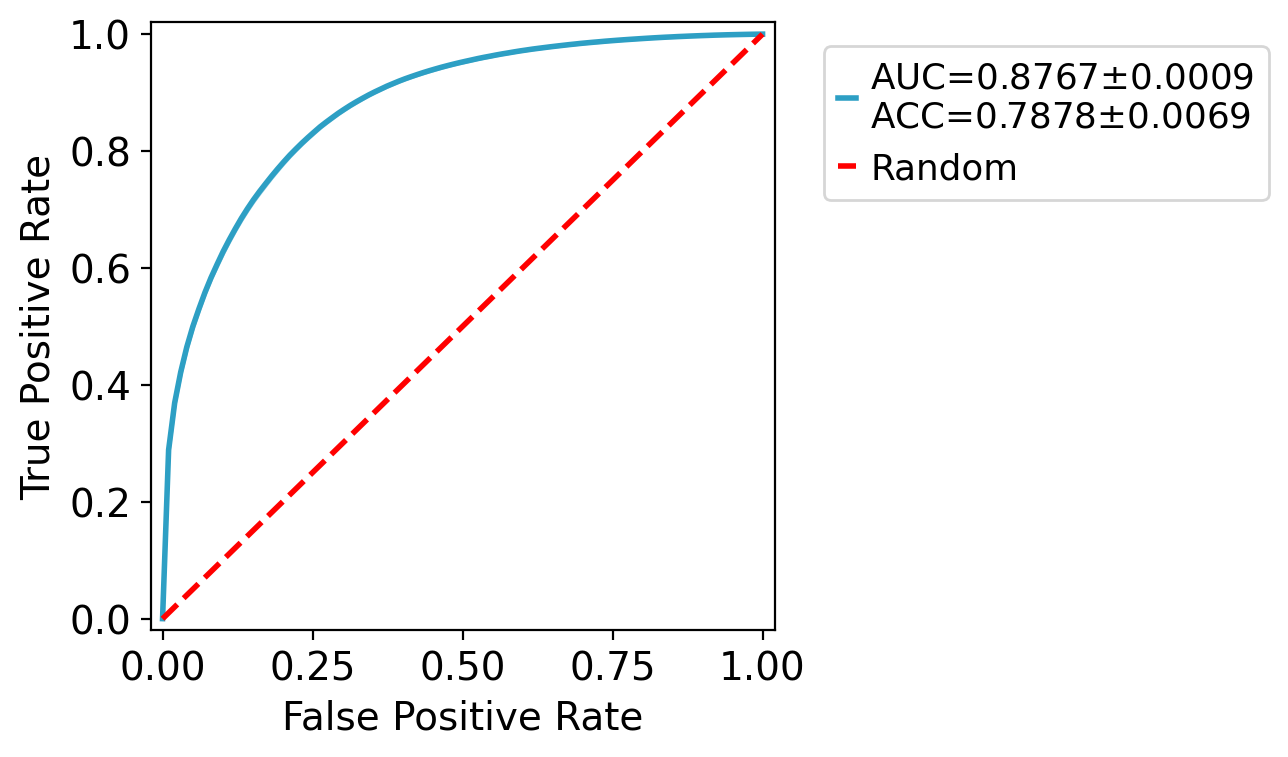

In [10]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# track values to compute mean value
mean_tprs, mean_fpr = [], np.linspace(0, 1, 100)
# plot the individual cv iterations
for fpr, tpr in zip(fprs, tprs):
    # grab the true positive rate when we interpolate
    mean_tprs.append(np.interp(mean_fpr, fpr, tpr))
#     # plot on this individual curve
#     ax.plot(fpr, tpr, color='tab:blue', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
# grab metrics for auc
mean_auc = np.mean(aucs)
ci95_auc = 1.96 * np.std(aucs) / np.sqrt(len(aucs))
# grab metrics for acc
mean_acc = np.mean(accs)
ci95_acc = 1.96 * np.std(accs) / np.sqrt(len(accs))
# plot the average iteration
mean_tpr = np.mean(mean_tprs, axis=0)
ax.plot(mean_fpr, mean_tpr, color='#2D9FC4', linewidth=2,
        label=r'AUC=%0.4f$\pm$%0.4f' % (mean_auc, ci95_auc) + '\n' +
        r'ACC=%0.4f$\pm$%0.4f' % (mean_acc, ci95_acc))
# plot the standard errors (95% CI actually)
ci95_tpr = 1.96 * np.std(mean_tprs, axis=0) / np.sqrt(len(mean_tprs))
mean_tprs_upper = np.minimum(mean_tpr + ci95_tpr, 1)
mean_tprs_lower = np.maximum(mean_tpr - ci95_tpr, 0)
ax.fill_between(mean_fpr, mean_tprs_lower, mean_tprs_upper, color='#2D9FC4', alpha=0.50)
# plot the random line
ax.plot([0,1], [0,1], color='r', linewidth=2, linestyle='--', label='Random')
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(1.05,0.99), bbox_transform=ax.transAxes)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')